## K-means Clustering (2 centroids vanilla example)

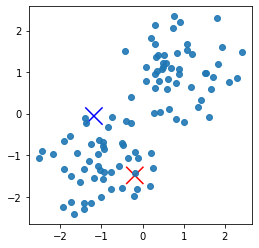

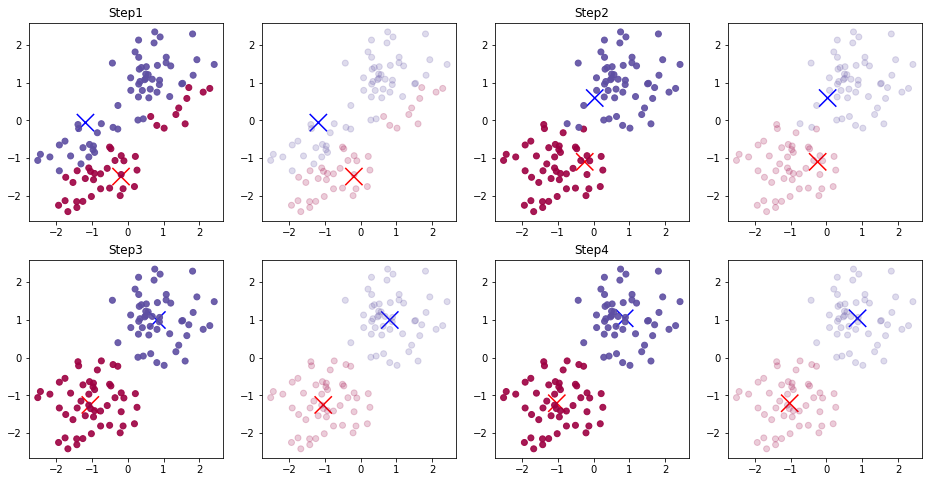

In [15]:
import torch
import matplotlib.pyplot as plt

n1 = 50
n2 = 50
n = n1 + n2
data1 = 0.7*torch.randn(n1, 2) + torch.tensor([1, 1])
data2 = 0.7*torch.randn(n2, 2) + torch.tensor([-1, -1])
data = torch.cat([data1, data2])

# initialise two centroids
centroid = torch.randn(2,2) 

# classfy every data point to one of the classes
# can be regarded as the E-step
def classify(data, centroid):
    dist = torch.cdist(centroid, data, p=2)
    out = []
    for i in range(dist.shape[1]):
        out.append(0 if dist[0, i] < dist[1, i] else 1)
    return torch.tensor(out)

# determine new centroid location based on current classification result
# (by finding their centre of gravity)
# can be regarted as the M-step
def determine(data, label):
    centroid1 = data[label==0].mean(0)
    centroid2 = data[label==1].mean(0)
    out = torch.cat([centroid1.reshape(1,-1), centroid2.reshape(1,-1)], axis=0)
    return out

plt.figure(figsize=(4,4))
plt.scatter(centroid[:,0], centroid[:,1], marker='x', s=300, color=['red','blue'])
plt.scatter(data[:,0], data[:,1], cmap = plt.cm.Spectral, alpha=0.9)

figure = plt.figure(figsize=(16, 8))
cols, rows = 2, 2
for i in range(cols * rows):
    label = classify(data, centroid) # classify data

    # plot result
    for j in range(1, 3):
        figure.add_subplot(rows, cols*2, i*2+j)
        if j==1:
            plt.scatter(centroid[:,0], centroid[:,1], marker='x', s=300, color=['red','blue'])
            plt.scatter(data[:,0], data[:,1], c=label, cmap = plt.cm.Spectral, alpha=0.9)
            plt.title(f'Step{i+1}')
        else:
            plt.scatter(centroid[:,0], centroid[:,1], marker='x', s=300, color=['red','blue'])
            plt.scatter(data[:,0], data[:,1], c=label, cmap = plt.cm.Spectral, alpha=0.2)

    centroid = determine(data, label) # move centroids

## EM Algorithm for MoG Estimation

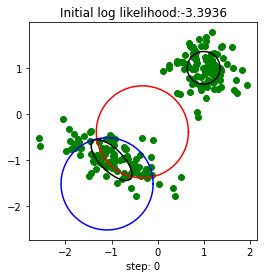

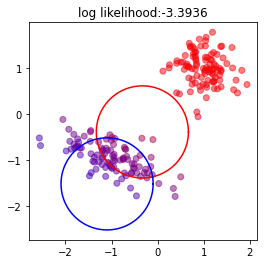

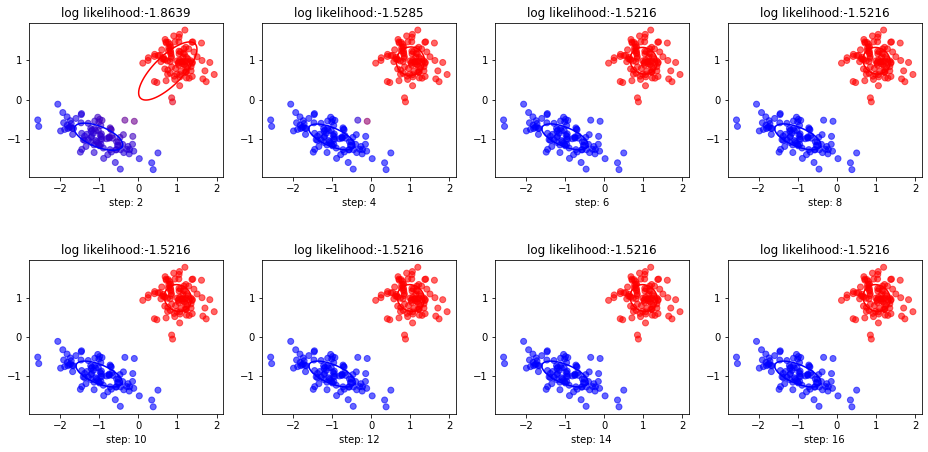

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def gauss_vis(mu, sigma):
    # return a set of points that visualise the 2d guassian distribution given its mean and covariance
    # eigenvalues and eigenvectors of the covariance matrix
    w, v = np.linalg.eig(sigma)
    theta = np.linspace(0, 2 * np.pi, 100)
    # axis of the ellipse
    y1 = np.reshape(v[:, 0] * np.sqrt(w[0]), (2, -1))
    y2 = np.reshape(v[:, 1] * np.sqrt(w[1]), (2, -1))
    # out will be a set of points constructing the ellipes
    out = y1 * np.cos(theta) + y2 * np.sin(theta)  + np.reshape(mu, (2, -1))
    return out

def generate_data():
    # put this process into a function so we can use the variable names can be reused
    n1 = 100
    n2 = 100
    n = n1 + n2
    mu1 = np.array([[1, 1]])
    mu2 = np.array([[-1, -1]])
    sigma1 = 0.7*np.random.rand(1)*np.array([[1, 0], [0, 1]])
    sigma2 = 0.7*np.random.rand(1)*np.array([[1, -0.7], [-0.7, 1]])
    L1 = np.linalg.cholesky(sigma1)
    L2 = np.linalg.cholesky(sigma2)
    data1 = np.random.randn(n1, 2) @ L1 + mu1 
    data2 = np.random.randn(n2, 2) @ L2 + mu2
    data = np.concatenate((data1, data2), axis=0)
    elli1 = gauss_vis(mu1, sigma1)
    elli2 = gauss_vis(mu2, sigma2)
    return data, elli1, elli2

def multivar_gauss_pdf(x, mu, sigma):
    d = x.shape[0] # dimension of data
    x_minus_mu = x - mu
    sigma_inv = np.linalg.solve(sigma, np.eye(2))
    out = (1/2/np.pi)**(d/2) * np.linalg.det(sigma)**(-1/2) * np.exp(-0.5 * x_minus_mu @ sigma_inv @ x_minus_mu.T)
    return out

# evaluate log likelihood
def log_likelihood(x, mu, sigma, pi):
    N = x.shape[0]
    K = len(pi)
    out = np.sum([np.log(np.sum([pi[k] * multivar_gauss_pdf(x[n], mu[k], sigma[k]) for k in range(K)])) for n in range(N)]) / N
    return out

# E-step
# finding the posterior p(z|x)
def E_step(x, mu, sigma):
    N, K = x.shape
    out = np.zeros_like(x)
    # finding p(z|x) one by one instead of a matrix multiplication manner, 
    # becasue if I formulate the probability like p(z|x[1])*..*p(z|x[N]),
    # numerical underflow will occur if N is large since 0<p<1. I don't know how to solve this issue
    # so I just use this dumb double for loops...
    for i in range(N):
        for j in range(K):
            out[i, j] = multivar_gauss_pdf(x[i], mu[j], sigma[j])
    out = out / np.sum(out, axis=1, keepdims=True)
    return out

# M-step
# finding mean, covariance and the new latent variable that maximise the log-likelihood
def M_step(x, R):
    N, K = R.shape
    N_k = np.ravel(np.ones((1, N)) @ R)
    # mean
    mu = [np.sum(x*R[:,k:k+1], axis=0, keepdims=True)/N_k[k] for k in range(K)]
    # covariance
    sigma = [(x-mu[k]).T @ np.diag(R[:,k]) @ (x-mu[k]) / N_k[k] for k in range(K)]
    # latent variable (the 'gauss mixing coefficient') 
    pi = N_k / N
    return mu, sigma, pi

# generate some data 
data, true_elli1, true_elli2 = generate_data()

# initialise mean (mu), covariance (sigma) and the latent variable p(z|x) (pi)
# K=2, put mu_1, mu_2 into a list, same as sigma
mu = [np.random.randn(1,2), np.random.randn(1,2)] 
sigma = [np.eye(2)] * 2
pi = np.array([0.5, 0.5])

# evaluate log likelihood (divided by number of data points N)
loss = log_likelihood(data, mu, sigma, pi)

# plot 
elli1 = gauss_vis(mu[0], sigma[0])
elli2 = gauss_vis(mu[1], sigma[1])
plt.figure()
ax = plt.gca()
ax.set_aspect(1)
plt.scatter(data[:,0], data[:,1], c='green')
plt.plot(elli1[0,:], elli1[1,:], c='red')
plt.plot(elli2[0,:], elli2[1,:], c='blue')
plt.plot(true_elli1[0,:], true_elli1[1,:], c='black')
plt.plot(true_elli2[0,:], true_elli2[1,:], c='black')
plt.title(f'Initial log likelihood:{loss:.4f}')
plt.xlabel('step: 0')

# plot 
R = E_step(data, mu, sigma)
colours = np.concatenate((R[:,0:1], np.zeros((R.shape[0],1)), R[:,1:2]), axis=1)
elli1 = gauss_vis(mu[0], sigma[0])
elli2 = gauss_vis(mu[1], sigma[1])
plt.figure()
ax = plt.gca()
ax.set_aspect(1)
plt.scatter(data[:,0], data[:,1], c=colours, alpha=0.5)
plt.plot(elli1[0,:], elli1[1,:], c='red')
plt.plot(elli2[0,:], elli2[1,:], c='blue')
#plt.plot(true_elli1[0,:], true_elli1[1,:], c='black')
#plt.plot(true_elli2[0,:], true_elli2[1,:], c='black') 
plt.title(f'log likelihood:{loss:.4f}')  


figure = plt.figure(figsize=(16,8))
cols = 4
rows = 2
for i in range(1, cols * rows + 1):
    update = 2
    for _ in range(update):
        # E step
        R = E_step(data, mu, sigma) # R stands for Responsibility
        # M step
        mu, sigma, pi = M_step(data, R)

    # evaluate log likelihood (divided by number of data points N)
    loss = log_likelihood(data, mu, sigma, pi)

    # plot 
    colours = np.concatenate((R[:,0:1], np.zeros((R.shape[0],1)), R[:,1:2]), axis=1)
    elli1 = gauss_vis(mu[0], sigma[0])
    elli2 = gauss_vis(mu[1], sigma[1])
    ax = figure.add_subplot(rows, cols, i)
    ax.set_aspect(1)
    plt.scatter(data[:,0], data[:,1], c=colours, alpha=0.6)
    plt.plot(elli1[0,:], elli1[1,:], c='red')
    plt.plot(elli2[0,:], elli2[1,:], c='blue')
    #plt.plot(true_elli1[0,:], true_elli1[1,:], c='black')
    #plt.plot(true_elli2[0,:], true_elli2[1,:], c='black') 
    plt.title(f'log likelihood:{loss:.4f}')  
    plt.xlabel(f'step: {i * update}')




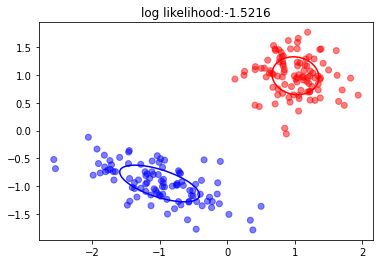

In [17]:
# if more iteration is needed to converge, just keep running this block
update = 20
for _ in range(update):
    # E step
    R = E_step(data, mu, sigma) # R stands for Responsibility
    # M step
    mu, sigma, pi = M_step(data, R)

# evaluate log likelihood (divided by number of data points N)
loss = log_likelihood(data, mu, sigma, pi)

# plot 
colours = np.concatenate((R[:,0:1], np.zeros((R.shape[0],1)), R[:,1:2]), axis=1)
elli1 = gauss_vis(mu[0], sigma[0])
elli2 = gauss_vis(mu[1], sigma[1])
plt.figure()
plt.scatter(data[:,0], data[:,1], c=colours,alpha=0.5)
plt.plot(elli1[0,:], elli1[1,:], c='red')
plt.plot(elli2[0,:], elli2[1,:], c='blue')
#plt.plot(true_elli1[0,:], true_elli1[1,:], c='black')
#plt.plot(true_elli2[0,:], true_elli2[1,:], c='black') 
plt.title(f'log likelihood:{loss:.4f}') 
plt.show() 

## Linear Regression

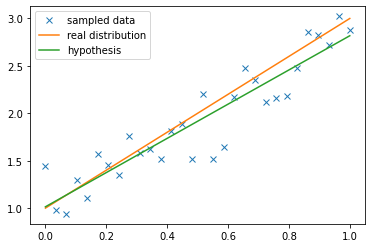

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def func1(x):
    out = 2 * x + 1
    return out 

# data set
x = np.linspace(0, 1, 30)
y = func1(x)+0.3*np.random.randn(len(x))

plt.plot(x, y, 'x')
plt.plot([min(x), max(x)],[func1(min(x)), func1(max(x))])

X = np.concatenate([[np.ones_like(x)], [x]],axis = 0).T
theta = np.linalg.inv(X.T @ X) @ X.T @ y
plt.plot([min(x), max(x)], [min(x)*theta[1]+theta[0], max(x)*theta[1]+theta[0]])
plt.legend(['sampled data', 'real distribution', 'hypothesis'])


## LMS with the kernal trick

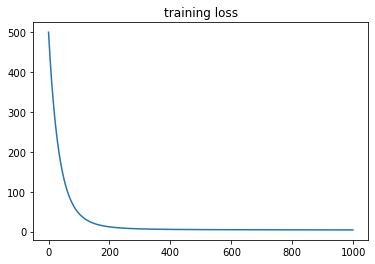

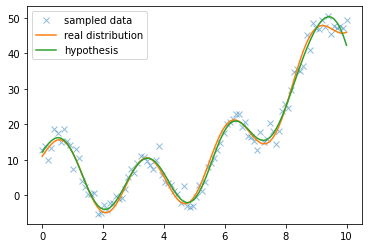

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

# the kernel function
# gaussian kernel 
def kernel(x, y):
    #out = (np.inner(x, y) + 1)**3
    out = np.exp(-(x-y)**2)
    return out 

# real distribution 
def func2(x):
    # just a weird function...
    out = (x - 3)**2 + 1 + 8 * np.sin(x*2 + 0.3 * x) + np.exp(x/10) 
    return out 

# data set
n = 100
x = np.linspace(0, 10, n).reshape(-1, 1)
y = func2(x)+2*np.random.randn(len(x), 1)
y_true = func2(x)

# kernel matrix
K = np.array([kernel(x[i], x[j]) for i in range(len(x)) for j in range(len(x))]).reshape(len(x), len(x))

alpha = 1e-3
beta = np.zeros([len(x), 1])

# loss function
def loss(K=K, y=y, beta=beta):
    out = K @ beta - y
    out = out.T @ out / len(beta)
    return out.item()

# training loop
lossi = []
for i in range(1000):
    lossi.append(loss(beta=beta))
    beta = beta + alpha * (y - K @ beta)

# predict function
def predict(x, training_x=x, beta=beta):
    out = np.sum([beta[i]*kernel(training_x[i], x) for i in range(len(training_x))])
    return out 

y_predict = [predict(i) for i in x]

# plot
plt.figure()
plt.plot(lossi)
plt.title('training loss')
plt.show()

plt.figure()
plt.plot(x, y, 'x', alpha=0.5)
plt.plot(x, y_true)
plt.plot(x, y_predict)
plt.legend(['sampled data', 'real distribution', 'hypothesis'])
plt.show()

## Support Vector Machine

/Users/brianwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


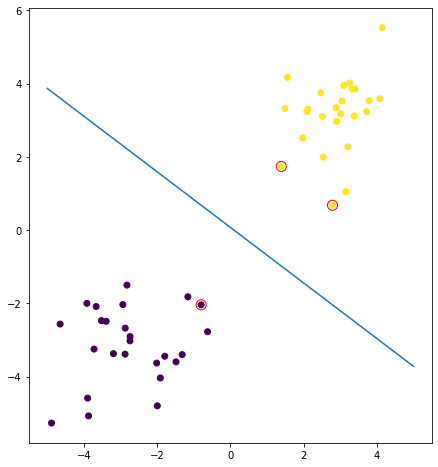

In [20]:
"""Vanilla SVM without kernel trick, or a kernel function"""

import numpy as np 
import matplotlib.pyplot as plt 
from cvxopt import matrix, solvers

# generate some data 
n = 50
n1 = int(n/2)
n2 = n - n1
centre1 = np.array([3, 3])
centre2 = np.array([-3, -3])
x1 = np.random.randn(n1, 2) + centre1
y1 = np.ones((n1, 1))
x2 = np.random.randn(n2, 2) + centre2 
y2 = -np.ones((n2, 1))
x = np.concatenate([x1, x2], axis=0)
y = np.concatenate([y1, y2], axis=0)

def solve(x, y):
    P = matrix(x @ x.T * (y @ y.T))
    q = matrix(-np.ones_like(y))
    G = matrix(-np.eye(len(y)))
    h = matrix(np.zeros_like(y))
    A = matrix(y.T)
    b = matrix(0.0)
    sol = solvers.qp(P, q, G, h, A, b)
    return sol['x']

alpha = np.array(solve(x, y))
alpha[alpha < 1e-6] = 0 # kill non-support vectors
alpha_index = np.where(alpha != 0)[0] # index of support vectors
w = np.sum(alpha[i] * y[i] * x[i:i+1, :] for i in alpha_index).T
b = -0.5 * (np.min(x[(y==1).reshape(-1)] @ w) + np.max(x[(y==-1).reshape(-1)] @ w))

def plot_fun(x, w=w, b=b):
    out = (-w[0]*x-b)/w[1]
    return out

# plot
plt.figure(figsize=(8,8))
ax = plt.gca()
ax.set_aspect(1)
plt.scatter(x[:, 0], x[:, 1], c=y) # plot data
plt.plot([-5, 5], [plot_fun(-5), plot_fun(5)])
# circle support vectors
plt.scatter(x[alpha_index, 0], x[alpha_index, 1], s=100, facecolors='none', edgecolors='r')
plt.show()

     pcost       dcost       gap    pres   dres
 0: -1.4620e+01 -1.2057e+03  5e+03  2e+00  1e-15
 1:  1.1815e-01 -4.4523e+02  6e+02  7e-02  1e-15
 2: -7.9123e+00 -7.8766e+01  8e+01  8e-03  1e-15
 3: -1.2057e+01 -5.5612e+01  5e+01  4e-03  9e-16
 4: -1.6040e+01 -3.3837e+01  2e+01  1e-03  9e-16
 5: -1.8006e+01 -2.4718e+01  7e+00  3e-04  9e-16
 6: -1.8945e+01 -2.1631e+01  3e+00  6e-05  9e-16
 7: -1.9440e+01 -2.0368e+01  9e-01  1e-05  9e-16
 8: -1.9663e+01 -1.9911e+01  2e-01  7e-07  1e-15
 9: -1.9667e+01 -1.9906e+01  2e-01  6e-07  1e-15
10: -1.9741e+01 -1.9800e+01  6e-02  7e-08  1e-15
11: -1.9764e+01 -1.9770e+01  6e-03  5e-09  1e-15
12: -1.9766e+01 -1.9767e+01  6e-04  5e-10  1e-15
13: -1.9766e+01 -1.9767e+01  8e-05  1e-11  1e-15
14: -1.9766e+01 -1.9766e+01  1e-06  2e-13  1e-15
Optimal solution found.
Training completed.
Total training time: 0.82s
Training accuracy: 100.0000%
Test accuracy: 100.0000%
Number of support vectors:  60


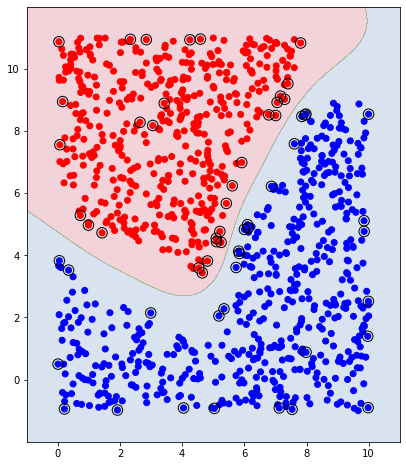

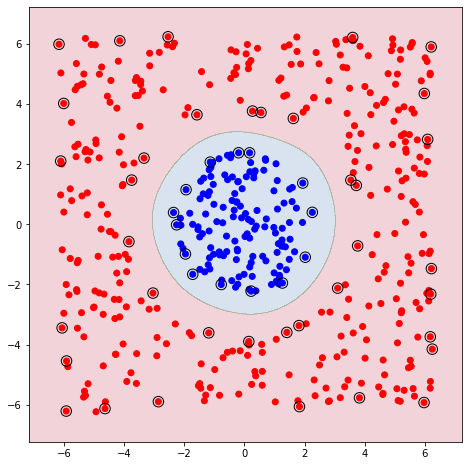

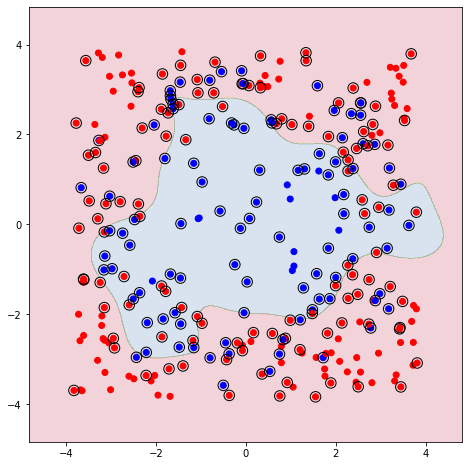

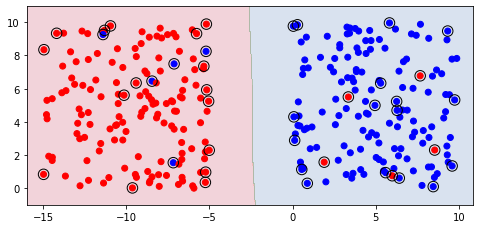

In the last example
Number of misclassified point (mislabelled in this case) =  10
Which comply with the rule that missclassified point will have its alpha = C


In [22]:
"""Soft margin SVM with Gaussian kernel"""
import numpy as np 
import matplotlib.pyplot as plt 
from cvxopt import matrix, solvers
import time

np.random.seed(seed=3407)

class SVM():

    def __init__(self, C, sigma):
        self.C = C # regularisation constant (C-SVM)
        self.sigma = sigma # used by the gaussian kernel function
        self.if_trained = False # if the SVM is trained

    # use gaussian kernel
    def kernel(self, x, z):
        if len(x.shape) == 1: 
            x = np.array([x]) 
        diff = x - z
        out = np.exp(-np.sum(diff * diff, axis=1) / (self.sigma)**2)
        return out

    # train the SVM
    def train(self, x, y, show_progress=False):  
        starting_time = time.time()

        n = x.shape[0] # num of data 

        # compute the kernel matrix
        self.K = np.array([self.kernel(x[i], x) for i in range(n)]).reshape(n, n) 

        # calculate the support vectors and its coefficient 
        alpha = np.array(self.solve(y, self.K, self.C, show_progress))
        alpha[alpha < 1e-5] = 0 # set non-support vector = 0 (due to numerical issues they were close to but not zero)
        alpha_index = np.where(alpha != 0)[0] # index for nonzero alpha
        self.alpha = alpha[alpha_index]
        self.sup_vec = x[alpha_index, :]
        self.sup_y = y[alpha_index] 
        self.num_sup_vec = len(self.alpha) # num of support vectors

        # calculate the 'b' (w.T @ x + b = y)
        m_index = np.arange(len(alpha))[((alpha >= 1e-5) * (alpha <= self.C-1e-8)).reshape(-1)] # index that 0 < alpha_i < C
        self.b = np.mean([y[i] - np.sum([alpha[j] * y[j] * self.K[i, j] for j in alpha_index]) for i in m_index])

        # mark model as trained
        self.if_trained = True

        if show_progress == True:
            print('Training completed.')
            print(f'Total training time: {time.time() - starting_time:.2f}s')
            print('='*40)

    # calculate the value of w.T @ phi(x_new) + b 
    # (decision bourndary: predict(x) = 0)
    def predict(self, x_new):
        if self.if_trained == False:
            raise Warning('SVM not trained yet.') 
        out = np.sum([self.alpha[i] * self.sup_y[i] * self.kernel(self.sup_vec[i], x_new) for i in range(self.num_sup_vec)], axis=0) + self.b
        return out

    # classify the predicted result
    def classify(self, x_new):
        out = self.predict(x_new)
        out = np.sign(out)
        return out
    
    # a QP solver for training the SVM (use cvxopt library)
    def solve(self, y, K, C, show_progress):
        P = matrix(K * (y @ y.T))
        q = matrix(-np.ones_like(y))
        G1 = np.eye(len(y))
        G2 = -np.eye(len(y))
        G = matrix(np.concatenate((G1, G2), axis=0))
        h1 = C * np.ones_like(y)
        h2 = np.zeros_like(y)
        h = matrix(np.concatenate((h1, h2), axis=0))
        A = matrix(y.T)
        b = matrix(0.0)
        solvers.options['show_progress'] = show_progress
        sol = solvers.qp(P, q, G, h, A, b)
        return sol['x']
    
    def plot_result(self, x, y):
        if self.if_trained == False:
            raise Warning('SVM not trained yet.') 
        # x, y are the training data/label. Feed them into this function just to plot them since they were ditched right after training. 
        # plot
        plt.figure(figsize=(8,8))
        ax = plt.gca()
        ax.set_aspect(1)
        # fill the decision regions
        x1min, x1max = x[:, 0].min() - 1, x[:, 0].max() + 1
        x2min, x2max = x[:, 1].min() - 1, x[:, 1].max() + 1
        hh = 0.01 # control the pixels for plotting decision regions. The smaller, the finer (but slower).
        X1, X2 = np.meshgrid(np.arange(x1min, x1max, hh), np.arange(x2min, x2max, hh))
        YY = self.classify(np.c_[X1.ravel(), X2.ravel()]).reshape(X1.shape)
        plt.contourf(X1, X2, YY, cmap = plt.cm.Spectral, alpha=0.2)

        # plot data
        label2colour = {-1:'red', 1:'blue'} # colour mappings
        ckey = [label2colour[i] for i in y.reshape(-1)] # colours for each point
        plt.scatter(x[:, 0], x[:, 1], c=ckey, cmap = plt.cm.Spectral) 
        # circle support vectors
        plt.scatter(self.sup_vec[:, 0], self.sup_vec[:, 1], s=110, facecolors='none', edgecolors='black')
        plt.show()

# data generator
def data_gen1(n):
    x = np.random.rand(n, 2) * 10 # data. dim(x) = (n, 2)
    def boundary(x, y):
        if ((x - 3)**2 + 1 + 3 * np.sin(x**2 / 5))/3 + 2 > y:
            return 1
        else:
            return -1
    y = np.array([boundary(x[i, 0], x[i, 1]) for i in range(n)], dtype=float) # label
    x[:, 1] -= y # make the data separable
    y = y.reshape(-1, 1)
    return x, y

# data generator- circular data
def data_gen2(n, a=0.8):
    x = (np.random.rand(n, 2) - 0.5) * 10 # data. dim(x) = (n, 2)
    def boundary(x, y):
        if x**2 + y**2 < 9:
            return 1
        else:
            return -1
    y = np.array([boundary(x[i, 0], x[i, 1]) for i in range(n)], dtype=float) # label
    # make the data separable or overlap
    x[y==1, :] *= a
    x[y==-1, :] *= 1/a
    y = y.reshape(-1, 1)
    return x, y

# linear seperable data but with few mislabelled data
def data_gen3(n, k):
    n1 = int(n/2)
    n2 = n - n1
    x1 = np.random.rand(n1, 2) * 10 # data. dim(x) = (n, 2)
    x2 = np.random.rand(n2, 2) * 10 + np.array([-15, 0])
    x = np.concatenate([x1, x2])
    y = np.ones((n, 1))
    y[n1:] *= -1
    # chosse some y to mislabel
    mislabelled = np.random.choice(len(y), k, replace=False)
    y[mislabelled] *= -1
    return x, y, mislabelled 

# generate some data 
x, y = data_gen1(1000)

# initialise the SVM
svm = SVM(C=1, sigma=2)

# train the SVM
svm.train(x, y, show_progress=True)

# print training accuracy
print(f'Training accuracy: {np.mean(svm.classify(x)==y.reshape(-1))*100:.4f}%')

# calculate test accuracy!
x_test, y_test = data_gen1(int(x.shape[0]*10)) # generator some test data 
print(f'Test accuracy: {np.mean(svm.classify(x_test)==y_test.reshape(-1))*100:.4f}%')

# num of sup_vec
print('Number of support vectors: ', svm.num_sup_vec)

#plot the resulting decision region and support vectors
svm.plot_result(x, y)

"""Let's try some more datasets"""
cc=1
x1, y1 = data_gen2(500)
svm1 = SVM(C=cc, sigma=2)
svm1.train(x1, y1)
svm1.plot_result(x1, y1)

x2, y2 = data_gen2(300, a = 1.3)
svm2 = SVM(C=cc, sigma=1)
svm2.train(x2, y2)
svm2.plot_result(x2, y2)

x3, y3, mislabelled = data_gen3(300, 10)
svm3 = SVM(C=cc, sigma=5)
svm3.train(x3, y3)
svm3.plot_result(x3, y3)

print('In the last example')
print('Number of misclassified point (mislabelled in this case) = ', len(svm3.alpha[svm3.C - svm3.alpha < 1e-8])) 
print('Which comply with the rule that missclassified point will have its alpha = C')